# Processing & Analysis
The code contained in this jupyter notebook will handle much if not most of the processing of the information gathered from `unpack.ipynb`. The code will assume that files have been generated from that script, following the regex pattern `"nyt-*.p"`  

At least one of these files are necessary to run, but the processing will provide best results if multiple are used.


### Table of Contents
- [Turn On Ability To See Multiple Outputs](#Turn-On-Ability-To-See-Multiple-Outputs)
- [Import Necessary Libraries](#Import-Necessary-Libraries)
- [Import List Created in focus_group.ipynb](#Import-List-Created-in-focus_group.ipynb)
- [Get Data from nyt-*.p Files For Each Person](#Get-Data-from-nyt-*.p-Files-For-Each-Person)
- [Get Opinion/Editoral Articles](#Get-Opinion/Editoral-Articles)
- [Remove Unusable Rows From opinion](#Remove-Unusable-Rows-From-opinion)
- [Apply a Function to Calculate Sentiment of Each Document Using VADER](#Apply-a-Function-to-Calculate-Sentiment-of- Each-Document-Using-VADER)
- [Use GroupBy to Aggregate Count Statistics](#Use-GroupBy-to-Aggregate-Count-Statistics)  

---

- [Who are the Top 10 Mentioned Names?](#Who-are-the-Top-10-Mentioned-Names?)
    - [Collect Count Statistics for Top 10](#Collect-Count-Statistics-for-Top-10)
    - [Visualize Sentiment Scores for Top 10](#Visualize-Sentiment-Scores-for-Top-10)

---

- [What Topics are Associated with Positive articles? Negative?](#What-Topics-are-Associated-with-Positive-Articles?- Negative?)
    - [Split the opinions DataFrame into POS and NEG DataFrames](#Split-the-opinions-DataFrame-into-POS-and-NEG- DataFrames)
    - [Gather Topics and Counts from pos_topics & Convert to DataFrame](#Gather-Topics-and-Counts-from-pos_topics-&-Convert-to-DataFrame)
    - [Gather Topics and Counts from neg_topics & Convert to DataFrame](#Gather-Topics-and-Counts-from-neg_topics-&-Convert-to-DataFrame)
    - [Aggregate Positive and Negative Topic Counts Together](#Aggregate-Positive-and-Negative-Topic-Counts-Together)
    - [Plot Counts of Positive Occurences of Top 20 Topics](#Plot-Counts-of-Positive-Occurences-of-Top-20-Topics)
    - [Plot Counts of Negative Occurences of Top 20 Topics](#Plot-Counts-of-Negative-Occurences-of-Top-20-Topics)
    - [Merge the Resulting pos and neg DataFrames into a Single topics DataFrame to Create Side-by-Side Bar Chart](#Merge-the-Resulting-pos-and-neg-DataFrames-into-a-Single-topics-DataFrame-to-Create-Side-by-Side-Bar-Chart)
    - [Visualize Side-by-Side POS and NEG data](#Visualize-Side-by-Side-POS-and-NEG-data)

---

- [What Are Common Feature Words in Negative Articles? What Are Common Words in Positive Articles?](#What-Are-Common- Feature-Words-in-Negative-Articles?-What-Are-Common-Words-in-Positive-Articles?)
    - [Collect and Tag Articles From pos_docs and neg_docs that Were Created Above](#Collect-and-Tag-Articles-From- pos_docs-and-neg_docs-that-Were-Created-Above)
    - [Create a Function to Extract Word Features](#Create-a-Function-to- Extract-Word-Features)
    - [Create a Feature Set for Sentiments](#Create-a-Feature-Set-for- Sentiments)
    - [Split feature_sets into a Training and Test Set](#Split-feature_sets-into-a-Training-and-Test-Set)
    - [Create the Naive-Bayes Classifier and Train It](#Create-the-Naive-Bayes-Classifier-and-Train-It)
    - [Measure Accuracy of Naive-Bayes Classifier](#Measure-Accuracy-of- Naive-Bayes-Classifier)
    - [Get the Most Informative Features From the Classifier](#Get-the- Most-Informative-Features-From-the-Classifier)
    
---    
    
- [Is There a Pattern Between Month and Sentiment?](#Is-There-a-Pattern- Between-Month-and-Sentiment?)
    - [Group opinions by Months](#Group-opinions-by-Months)
    - [Visualize Sentiment Averages over Months](#Visualize-Sentiment- Averages-over-Months)
    - [Peek at the Articles from April (4) and May (5)](#Peek-at-the-Articles-from-April-4-and-May-5)

### Turn On Ability To See Multiple Outputs

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Import Necessary Libraries

In [2]:
import xml.etree.ElementTree as Et
import glob
import pandas as pd
import nltk
from nltk.corpus import stopwords
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from random import shuffle

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Import List Created in `focus_group.ipynb`

In [3]:
names = pickle.load(open("poi.p", "rb"))
names

['TRUMP, DONALD',
 'OBAMA, BARACK',
 'BUSH, GEORGE W.',
 'CLINTON, BILL',
 'BUSH, GEORGE H.W.',
 'REAGAN, RONALD']

### Get Data from `nyt-*.p` Files For Each Person 

In [4]:
names_df = {}

In [5]:
for name in names:
    df = None
    for file in glob.glob("nyt-*.p"):
        data = pickle.load(open(file, 'rb'))
        if df is None:
            df = data[data['Name'] == name]
        elif df is not None:
            df = pd.concat([df, data[data['Name'] == name]])
    names_df[name] = df

In [6]:
names_df.get(names[1]).head()

,DOCID,Date,Month,Year,Name,Text,Doctypes
88130,1621987,25,10,2004,"OBAMA, BARACK","in this country, big men have traditionally ta...",ELECTIONS|TOP/NEWS|TOP/NEWS/WORLD|TOP/NEWS/WOR...
76340,1622468,27,10,2004,"OBAMA, BARACK",barack obama drove to milwaukee the other day ...,ELECTIONS|FINANCES|PUBLIC OPINION|TOP/NEWS/U.S...
58763,1624419,3,11,2004,"OBAMA, BARACK",republicans made significant gains in senate r...,ELECTIONS|ELECTION RESULTS|UNITED STATES POLIT...
58765,1624419,3,11,2004,"OBAMA, BARACK",republicans made significant gains in senate r...,ELECTIONS|ELECTION RESULTS|UNITED STATES POLIT...
59373,1624555,4,11,2004,"OBAMA, BARACK","oklahoma tom coburn republican, 56. dr. cobu...",BIOGRAPHICAL INFORMATION|ELECTIONS|TOP/NEWS/WO...


### Get Opinion/Editoral Articles

In [7]:
opinions = None
for file in glob.glob("nyt-*.p"):
    data = pickle.load(open(file, 'rb'))
    if opinions is None:
        opinions = data[data['Doctypes'].str.contains("OPINION")]
    elif opinions is not None:
        new_df = data[data['Doctypes'].str.contains("OPINION")]
        opinions = pd.concat([opinions, new_df])
opinions = opinions.reset_index(drop=True)
opinions.head()

,DOCID,Date,Month,Year,Name,Text,Doctypes
0,1547308,1,1,2004,"POWELL, COLIN L (SEC)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...
1,1547308,1,1,2004,"BUSH, GEORGE W (PRES)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...
2,1547308,1,1,2004,"POWELL, COLIN L",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...
3,1547331,1,1,2004,"JOHNSON, STEPHEN",to the editor:,EARTHQUAKES|FOREIGN AID|LETTER|TOP/OPINION/OPI...
4,1547332,1,1,2004,"CAREY, CORINNE A",to the editor:,DRUG ABUSE AND TRAFFIC|LAW AND LEGISLATION|AMN...


### Remove Unusable Rows From `opinion`

In [8]:
opinions = opinions[opinions['Text'].str.len() > 15]
opinions.head()

,DOCID,Date,Month,Year,Name,Text,Doctypes
0,1547308,1,1,2004,"POWELL, COLIN L (SEC)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...
1,1547308,1,1,2004,"BUSH, GEORGE W (PRES)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...
2,1547308,1,1,2004,"POWELL, COLIN L",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...
7,1547382,1,1,2004,"NAGOURNEY, ADAM",when democratic party officials devised their ...,PRESIDENTIAL ELECTION OF 2004|PRIMARIES|PUBLIC...
8,1547382,1,1,2004,"DEAN, HOWARD (DR)",when democratic party officials devised their ...,PRESIDENTIAL ELECTION OF 2004|PRIMARIES|PUBLIC...


### Apply a Function to Calculate Sentiment of Each Document Using VADER

In [9]:
sia = SentimentIntensityAnalyzer()

def getScores(x):
    scores = sia.polarity_scores(x['Text'])
    x['POS'] = scores.get('pos')
    x['NEG'] = scores.get('neg')
    x['NEU'] = scores.get('neu')
    x['COM'] = scores.get('compound')
    return x

opinions = opinions.apply(getScores, axis=1)
opinions.head()

,DOCID,Date,Month,Year,Name,Text,Doctypes,POS,NEG,NEU,COM
0,1547308,1,1,2004,"POWELL, COLIN L (SEC)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
1,1547308,1,1,2004,"BUSH, GEORGE W (PRES)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
2,1547308,1,1,2004,"POWELL, COLIN L",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
7,1547382,1,1,2004,"NAGOURNEY, ADAM",when democratic party officials devised their ...,PRESIDENTIAL ELECTION OF 2004|PRIMARIES|PUBLIC...,0.118,0.000,0.882,0.5267
8,1547382,1,1,2004,"DEAN, HOWARD (DR)",when democratic party officials devised their ...,PRESIDENTIAL ELECTION OF 2004|PRIMARIES|PUBLIC...,0.118,0.000,0.882,0.5267


### Use GroupBy to Aggregate Count Statistics
Get the top 10 mentions in Opinion based articles.  
Using the describe function, I can get the mean of the COM score, as well as their counts.

In [10]:
com_stats = opinions['COM'].groupby(opinions['Name']).describe().reset_index()
com_stats = com_stats.sort_values(by='count', ascending=False)
com_stats.head(10)

,Name,count,mean,std,min,25%,50%,75%,max
2159,"BUSH, GEORGE W (PRES)",4569.0,-0.037078,0.619283,-0.9954,-0.62270,0.00000,0.54230,0.9811
2157,"BUSH, GEORGE W",2207.0,-0.055041,0.619554,-0.9954,-0.63690,-0.01290,0.53380,0.9718
2158,"BUSH, GEORGE W (GOV)",729.0,0.186683,0.538973,-0.9853,-0.22630,0.26170,0.65970,0.9891
8638,"KRUGMAN, PAUL",610.0,-0.001157,0.594780,-0.9743,-0.57190,0.00000,0.54205,0.9625
6775,"HERBERT, BOB",584.0,-0.095764,0.560188,-0.9861,-0.61240,0.00000,0.36120,0.9674
5819,"GORE, AL (VICE PRES)",580.0,0.201823,0.512797,-0.9674,-0.16735,0.25455,0.63690,0.9891
5121,"FRIEDMAN, THOMAS L",573.0,-0.016703,0.614318,-0.9912,-0.56470,0.00000,0.54860,0.9824
8150,"KERRY, JOHN (SEN)",559.0,0.044203,0.573339,-0.9954,-0.44040,0.00000,0.54985,0.9831
3991,"DOWD, MAUREEN",531.0,-0.009042,0.444009,-0.9652,-0.34000,0.00000,0.34000,0.9723
13702,"SAFIRE, WILLIAM",485.0,-0.002569,0.528263,-0.9779,-0.42150,0.00000,0.44040,0.9501


# Who are the Top 10 Mentioned Names?

### Collect Count Statistics for Top 10

In [11]:
top_10 = com_stats.head(10)
top_10

,Name,count,mean,std,min,25%,50%,75%,max
2159,"BUSH, GEORGE W (PRES)",4569.0,-0.037078,0.619283,-0.9954,-0.62270,0.00000,0.54230,0.9811
2157,"BUSH, GEORGE W",2207.0,-0.055041,0.619554,-0.9954,-0.63690,-0.01290,0.53380,0.9718
2158,"BUSH, GEORGE W (GOV)",729.0,0.186683,0.538973,-0.9853,-0.22630,0.26170,0.65970,0.9891
8638,"KRUGMAN, PAUL",610.0,-0.001157,0.594780,-0.9743,-0.57190,0.00000,0.54205,0.9625
6775,"HERBERT, BOB",584.0,-0.095764,0.560188,-0.9861,-0.61240,0.00000,0.36120,0.9674
5819,"GORE, AL (VICE PRES)",580.0,0.201823,0.512797,-0.9674,-0.16735,0.25455,0.63690,0.9891
5121,"FRIEDMAN, THOMAS L",573.0,-0.016703,0.614318,-0.9912,-0.56470,0.00000,0.54860,0.9824
8150,"KERRY, JOHN (SEN)",559.0,0.044203,0.573339,-0.9954,-0.44040,0.00000,0.54985,0.9831
3991,"DOWD, MAUREEN",531.0,-0.009042,0.444009,-0.9652,-0.34000,0.00000,0.34000,0.9723
13702,"SAFIRE, WILLIAM",485.0,-0.002569,0.528263,-0.9779,-0.42150,0.00000,0.44040,0.9501


### Visualize Sentiment Scores for Top 10

(array([-0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25]),
 <a list of 8 Text xticklabel objects>)

(-0.25, 0.25)

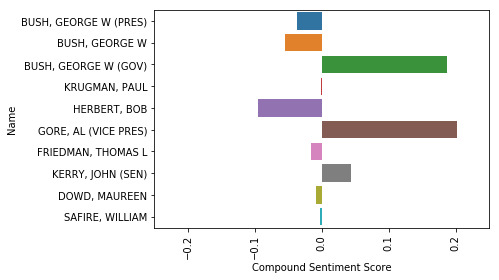

In [12]:
ax = sns.barplot(x='mean', y='Name', data=top_10)
plt.xticks(rotation=90)
plt.xlim([-0.25, .25])
plt.xlabel("Compound Sentiment Score")
plt.show()

# What Topics are Associated with Positive Articles? Negative?

### Split the `opinions` DataFrame into `POS` and `NEG` DataFrames

In [13]:
pos_docs = opinions[opinions['COM'] > 0]
neg_docs = opinions[opinions['COM'] < 0]

In [14]:
pos_docs.head()
neg_docs.head()

,DOCID,Date,Month,Year,Name,Text,Doctypes,POS,NEG,NEU,COM
0,1547308,1,1,2004,"POWELL, COLIN L (SEC)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
1,1547308,1,1,2004,"BUSH, GEORGE W (PRES)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
2,1547308,1,1,2004,"POWELL, COLIN L",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
7,1547382,1,1,2004,"NAGOURNEY, ADAM",when democratic party officials devised their ...,PRESIDENTIAL ELECTION OF 2004|PRIMARIES|PUBLIC...,0.118,0.000,0.882,0.5267
8,1547382,1,1,2004,"DEAN, HOWARD (DR)",when democratic party officials devised their ...,PRESIDENTIAL ELECTION OF 2004|PRIMARIES|PUBLIC...,0.118,0.000,0.882,0.5267


,DOCID,Date,Month,Year,Name,Text,Doctypes,POS,NEG,NEU,COM
38,1549482,10,1,2004,"STEIN, SETH (PROF)","in defending against disasters, society plays ...",EARTHQUAKES|BUILDING (CONSTRUCTION)|MEDICINE A...,0.106,0.196,0.698,-0.9252
39,1549482,10,1,2004,"TOMASELLO, JOSEPH","in defending against disasters, society plays ...",EARTHQUAKES|BUILDING (CONSTRUCTION)|MEDICINE A...,0.106,0.196,0.698,-0.9252
40,1549482,10,1,2004,"STEIN, SETH","in defending against disasters, society plays ...",EARTHQUAKES|BUILDING (CONSTRUCTION)|MEDICINE A...,0.106,0.196,0.698,-0.9252
41,1549523,10,1,2004,"BUSH, GEORGE W (PRES)","when president bush campaigns for re-election,...",EDUCATION AND SCHOOLS|EDITORIALS|STATES (US)|F...,0.081,0.117,0.802,-0.5574
42,1549523,10,1,2004,"BUSH, GEORGE W","when president bush campaigns for re-election,...",EDUCATION AND SCHOOLS|EDITORIALS|STATES (US)|F...,0.081,0.117,0.802,-0.5574


### Gather Topics and Counts from `pos_topics` & Convert to DataFrame

In [15]:
pos_topics = {}
for row in pos_docs.itertuples(index=True, name='Pandas'):
    topics_string = getattr(row, 'Doctypes')
    topics = topics_string.split('|')
    for t in topics:
        if t != "" and not t.startswith("TOP"):
            if t in pos_topics:
                pos_topics[t] += 1
            else:
                pos_topics[t] = 1
                
pos_topics_df = pd.DataFrame(list(pos_topics.items()), columns = ['Topic', 'Count'])
pos_topics_df = pos_topics_df.sort_values(by='Count', ascending=False).reset_index()
pos_topics_df["Sent"] = "POS"
pos_topics_df.head(20)

,index,Topic,Count,Sent
0,13,POLITICS AND GOVERNMENT,22404,POS
1,12,UNITED STATES POLITICS AND GOVERNMENT,16169,POS
2,0,UNITED STATES INTERNATIONAL RELATIONS,15484,POS
3,3,ELECTIONS,13133,POS
4,16,PUBLIC OPINION,11437,POS
5,8,OP-ED,11027,POS
6,17,PRESIDENTIAL ELECTIONS (US),10101,POS
7,5,TERRORISM,8495,POS
8,34,EDITORIAL,7421,POS
9,4,UNITED STATES ARMAMENT AND DEFENSE,7337,POS


### Gather Topics and Counts from `neg_topics` & Convert to DataFrame

In [16]:
neg_topics = {}
for row in neg_docs.itertuples(index=True, name='Pandas'):
    topics_string = getattr(row, 'Doctypes')
    topics = topics_string.split('|')
    for t in topics:
        if t != "" and not t.startswith("TOP"):
            if t in neg_topics:
                neg_topics[t] += 1
            else:
                neg_topics[t] = 1
                
neg_topics_df = pd.DataFrame(list(neg_topics.items()), columns = ['Topic', 'Count'])
neg_topics_df = neg_topics_df.sort_values(by='Count', ascending=False).reset_index()
neg_topics_df["Sent"] = "NEG"
neg_topics_df.head(20)

,index,Topic,Count,Sent
0,21,UNITED STATES INTERNATIONAL RELATIONS,20537,NEG
1,11,POLITICS AND GOVERNMENT,20401,NEG
2,28,UNITED STATES POLITICS AND GOVERNMENT,14992,NEG
3,25,TERRORISM,14365,NEG
4,47,PUBLIC OPINION,11641,NEG
5,24,UNITED STATES ARMAMENT AND DEFENSE,11345,NEG
6,7,OP-ED,10352,NEG
7,73,ELECTIONS,9412,NEG
8,26,INTERNATIONAL RELATIONS,8119,NEG
9,78,PRESIDENTIAL ELECTIONS (US),7812,NEG


### Aggregate Positive and Negative Topic Counts Together

In [17]:
topics_totals_df = pd.merge(pos_topics_df, neg_topics_df, left_on='Topic', right_on='Topic').reset_index(drop=True)
topics_totals_df = topics_totals_df.drop(['index_x', 'index_y'], axis=1)
topics_totals_df['Total Count'] = topics_totals_df['Count_x'] + topics_totals_df['Count_y']
topics_totals_df = topics_totals_df.head(20).sort_values(by='Total Count', ascending=False)
topics_totals_df

,Topic,Count_x,Sent_x,Count_y,Sent_y,Total Count
0,POLITICS AND GOVERNMENT,22404,POS,20401,NEG,42805
2,UNITED STATES INTERNATIONAL RELATIONS,15484,POS,20537,NEG,36021
1,UNITED STATES POLITICS AND GOVERNMENT,16169,POS,14992,NEG,31161
4,PUBLIC OPINION,11437,POS,11641,NEG,23078
7,TERRORISM,8495,POS,14365,NEG,22860
3,ELECTIONS,13133,POS,9412,NEG,22545
5,OP-ED,11027,POS,10352,NEG,21379
9,UNITED STATES ARMAMENT AND DEFENSE,7337,POS,11345,NEG,18682
6,PRESIDENTIAL ELECTIONS (US),10101,POS,7812,NEG,17913
13,INTERNATIONAL RELATIONS,6447,POS,8119,NEG,14566


### Plot Counts of Positive Occurences of Top 20 Topics

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

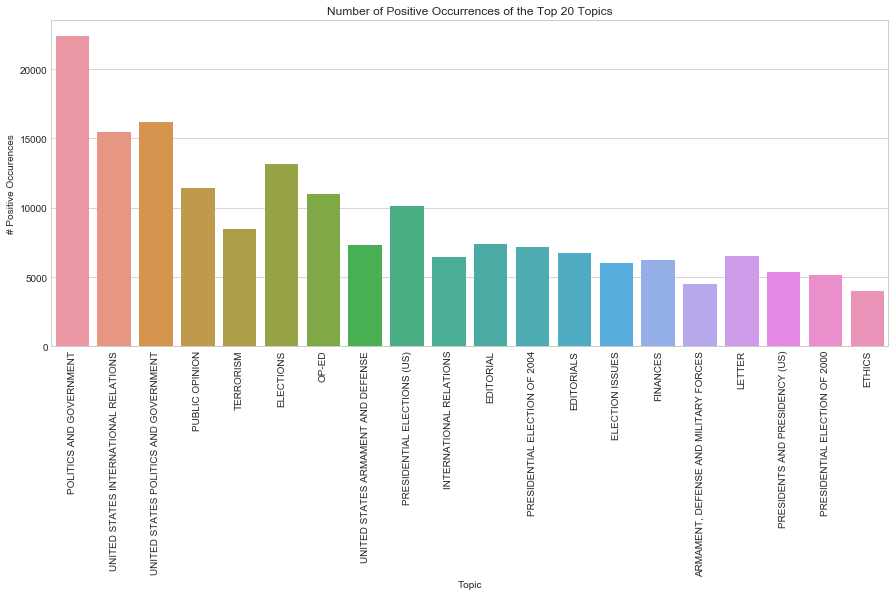

In [18]:
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
sns.barplot(x="Topic", y="Count_x", data=topics_totals_df)
plt.xticks(rotation=90)
plt.title("Number of Positive Occurrences of the Top 20 Topics")
plt.ylabel("# Positive Occurences")
plt.show()

### Plot Counts of Negative Occurences of Top 20 Topics

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

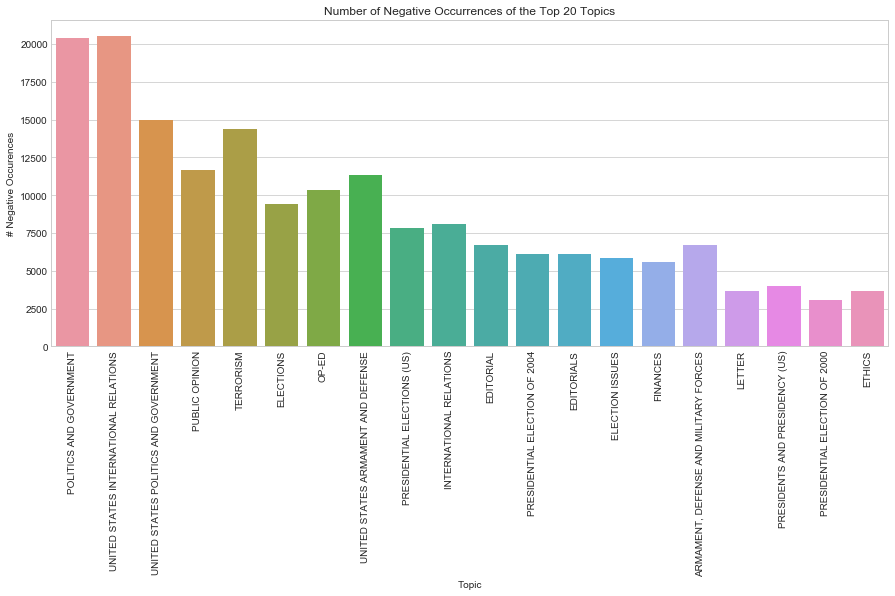

In [19]:
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
sns.barplot(x="Topic", y="Count_y", data=topics_totals_df)
plt.xticks(rotation=90)
plt.title("Number of Negative Occurrences of the Top 20 Topics")
plt.ylabel("# Negative Occurences")
plt.show()

### Merge the Resulting `pos` and `neg` DataFrames into a Single `topics` DataFrame to Create Side-by-Side Bar Chart

In [20]:
temp = pd.merge(pos_topics_df, neg_topics_df, left_on='Topic', right_on='Topic').reset_index(drop=True)
temp["Total"] = temp["Count_x"] + temp["Count_y"]
temp = temp.sort_values(by="Total", ascending=False)
temp = temp.set_index("Topic")
temp = temp.drop(['index_x', 'Count_x', 'Sent_x', 'index_y', 'Count_y', 'Sent_y'], axis=1)
temp = temp.to_dict()

topics_df = pd.concat([pos_topics_df, neg_topics_df]).reset_index(drop=True)
topics_df = topics_df.sort_values(by="Topic")

def getTotal(x):
    x['Total'] = temp.get("Total").get(x.Topic)
    return x

topics_df = topics_df.apply(getTotal, axis=1)
topics_df = topics_df.sort_values(by='Total', ascending=False).head(20)
topics_df

,index,Topic,Count,Sent,Total
0,13,POLITICS AND GOVERNMENT,22404,POS,42805.0
2177,11,POLITICS AND GOVERNMENT,20401,NEG,42805.0
2176,21,UNITED STATES INTERNATIONAL RELATIONS,20537,NEG,36021.0
2,0,UNITED STATES INTERNATIONAL RELATIONS,15484,POS,36021.0
2178,28,UNITED STATES POLITICS AND GOVERNMENT,14992,NEG,31161.0
1,12,UNITED STATES POLITICS AND GOVERNMENT,16169,POS,31161.0
4,16,PUBLIC OPINION,11437,POS,23078.0
2180,47,PUBLIC OPINION,11641,NEG,23078.0
7,5,TERRORISM,8495,POS,22860.0
2179,25,TERRORISM,14365,NEG,22860.0


### Visualize Side-by-Side POS and NEG data

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text xticklabel objects>)

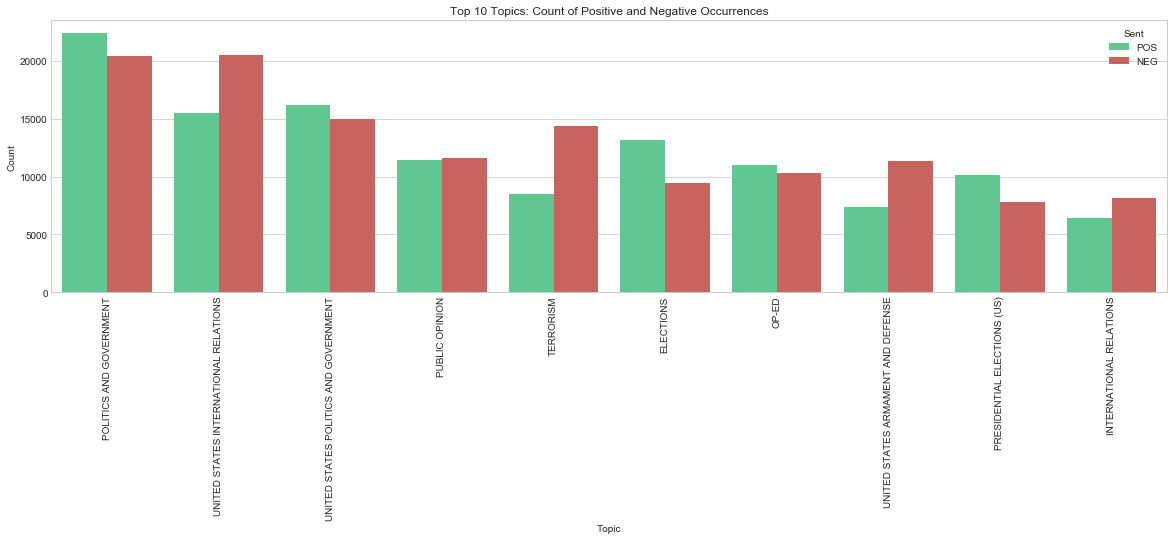

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
plt.xticks(rotation=90)
sns.barplot(x='Topic', y='Count', hue='Sent', data=topics_df, ax=ax, palette=['#4ed88e', '#d8544e'])
plt.title("Top 10 Topics: Count of Positive and Negative Occurrences")
plt.show()

# What Are Common Feature Words in Negative Articles? What Are Common Words in Positive Articles?

### Collect and Tag Articles From `pos_docs` and `neg_docs` that Were Created Above

In [22]:
labeled_articles = ([(row['Text'], 'neg') for ix, row in neg_docs.iterrows()] + 
                   [(row['Text'], 'pos') for ix, row in pos_docs.iterrows()])

In [23]:
shuffle(labeled_articles)

### Create a Function to Extract Word Features

In [24]:
def word_features(text):
    return dict([(word, True) for word in text.split()])

### Create a Feature Set for Sentiments

In [25]:
feature_sets = [(word_features(t), sent) for (t, sent) in labeled_articles]

### Split `feature_sets` into a Training and Test Set

In [26]:
train_set, test_set = feature_sets[500:], feature_sets[:500]

### Create the Naive-Bayes Classifier and Train It

In [27]:
nb_classifier = nltk.NaiveBayesClassifier.train(train_set)

### Measure Accuracy of Naive-Bayes Classifier

In [28]:
print(nltk.classify.accuracy(nb_classifier, test_set))

0.906


### Get the Most Informative Features From the Classifier

In [29]:
nb_classifier.show_most_informative_features(50)

Most Informative Features
                 killing = True              neg : pos    =     43.0 : 1.0
                prisoner = True              neg : pos    =     42.3 : 1.0
                  crime. = True              neg : pos    =     40.7 : 1.0
                murdered = True              neg : pos    =     33.7 : 1.0
               recommend = True              pos : neg    =     31.8 : 1.0
                   crude = True              neg : pos    =     28.3 : 1.0
                 horrors = True              neg : pos    =     27.5 : 1.0
               appalling = True              neg : pos    =     27.5 : 1.0
                 attack, = True              neg : pos    =     27.1 : 1.0
              terrifying = True              neg : pos    =     26.7 : 1.0
                   raped = True              neg : pos    =     26.0 : 1.0
              nightmare. = True              neg : pos    =     23.6 : 1.0
                  lovely = True              pos : neg    =     23.2 : 1.0

# Is There a Pattern Between Month and Sentiment? 

In [30]:
opinions.head()

,DOCID,Date,Month,Year,Name,Text,Doctypes,POS,NEG,NEU,COM
0,1547308,1,1,2004,"POWELL, COLIN L (SEC)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
1,1547308,1,1,2004,"BUSH, GEORGE W (PRES)",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
2,1547308,1,1,2004,"POWELL, COLIN L",as we americans turn the last page of our cale...,UNITED STATES INTERNATIONAL RELATIONS|FREEDOM ...,0.083,0.044,0.873,0.5574
7,1547382,1,1,2004,"NAGOURNEY, ADAM",when democratic party officials devised their ...,PRESIDENTIAL ELECTION OF 2004|PRIMARIES|PUBLIC...,0.118,0.000,0.882,0.5267
8,1547382,1,1,2004,"DEAN, HOWARD (DR)",when democratic party officials devised their ...,PRESIDENTIAL ELECTION OF 2004|PRIMARIES|PUBLIC...,0.118,0.000,0.882,0.5267


### Group `opinions` by Months

In [31]:
months = opinions["COM"].groupby(opinions["Month"]).describe().reset_index()
months['Month'] = months['Month'].apply(pd.to_numeric, errors='coerce')
months.sort_values(by='Month', ascending=True)

,Month,count,mean,std,min,25%,50%,75%,max
0,1,5887.0,0.060427,0.595791,-0.9913,-0.4588,0.0000,0.61700,0.9911
4,2,5779.0,0.092760,0.588402,-0.9925,-0.4019,0.0516,0.63690,0.9873
5,3,6253.0,0.000710,0.602979,-0.9922,-0.5439,0.0000,0.54230,0.9869
6,4,5930.0,-0.002410,0.606464,-0.9948,-0.5862,0.0000,0.55690,0.9883
7,5,5468.0,-0.003878,0.615256,-0.9917,-0.5859,0.0000,0.58090,0.9824
8,6,4796.0,0.044913,0.606489,-0.9926,-0.5106,0.0207,0.59940,0.9821
9,7,4628.0,0.063261,0.594056,-0.9859,-0.4588,0.0000,0.61925,0.9870
10,8,4823.0,0.067291,0.605354,-0.9837,-0.4774,0.0258,0.63690,0.9859
11,9,5039.0,0.051448,0.609082,-0.9954,-0.5106,0.0000,0.62090,0.9786
1,10,5159.0,0.009446,0.592457,-0.9942,-0.5267,0.0000,0.54990,0.9805


### Visualize Sentiment Averages over Months

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

(-0.02, 0.1)

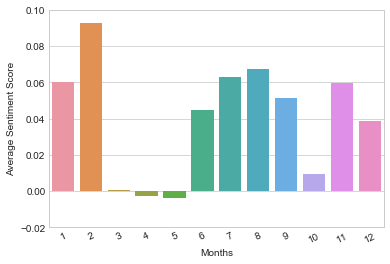

In [32]:
ax = sns.barplot(x='Month', y='mean', data=months)
plt.xticks(rotation=25)
plt.xlabel("Months")
plt.ylabel("Average Sentiment Score")
plt.ylim([-.02, .1])
plt.show()

### Peek at the Articles from April 4 and May 5

In [33]:
april = opinions[opinions["Month"] == "4"]
april.head()
april.tail()

,DOCID,Date,Month,Year,Name,Text,Doctypes,POS,NEG,NEU,COM
12156,1570798,1,4,2004,"KRUEGER, ALAN B","if you are reading this column, it is clear th...",ECONOMICS|PUBLIC OPINION|TOP/NEWS/BUSINESS/COL...,0.093,0.000,0.907,0.5588
12157,1570798,1,4,2004,"SLEMROD, JOEL","if you are reading this column, it is clear th...",ECONOMICS|PUBLIC OPINION|TOP/NEWS/BUSINESS/COL...,0.093,0.000,0.907,0.5588
12161,1570822,1,4,2004,"PATAKI, GEORGE E (GOV)",today marks the 20th anniversary of overdue bu...,EDUCATION AND SCHOOLS|EDITORIALS|FINANCES|BUDG...,0.024,0.117,0.858,-0.8299
12165,1570826,1,4,2004,"DOWD, MAUREEN",following is the text of a letter sent yesterd...,TERRORISM|AIRLINES AND AIRPLANES|HIJACKING|WOR...,0.000,0.000,1.000,0.0000
12166,1570826,1,4,2004,"BUSH, GEORGE W (PRES)",following is the text of a letter sent yesterd...,TERRORISM|AIRLINES AND AIRPLANES|HIJACKING|WOR...,0.000,0.000,1.000,0.0000


,DOCID,Date,Month,Year,Name,Text,Doctypes,POS,NEG,NEU,COM
117583,1284406,9,4,2001,"LEVY, HAROLD","last wednesday morning, sandra lerner, a board...",EDUCATION AND SCHOOLS|JEWS|OP-ED|TOP/OPINION/O...,0.000,0.000,1.000,0.0000
117584,1284410,9,4,2001,JIANG ZEMIN (PRES),china's insistence on a formal american apolog...,EDITORIALS|UNITED STATES INTERNATIONAL RELATIO...,0.069,0.085,0.846,-0.2263
117585,1284410,9,4,2001,CHI HAOTIAN (MIN),china's insistence on a formal american apolog...,EDITORIALS|UNITED STATES INTERNATIONAL RELATIO...,0.069,0.085,0.846,-0.2263
117586,1284410,9,4,2001,"POWELL, COLIN",china's insistence on a formal american apolog...,EDITORIALS|UNITED STATES INTERNATIONAL RELATIO...,0.069,0.085,0.846,-0.2263
117587,1284410,9,4,2001,"ZEMIN, JIANG",china's insistence on a formal american apolog...,EDITORIALS|UNITED STATES INTERNATIONAL RELATIO...,0.069,0.085,0.846,-0.2263


In [34]:
may = opinions[opinions["Month"] == "5"]
may.head()
may.tail()

,DOCID,Date,Month,Year,Name,Text,Doctypes,POS,NEG,NEU,COM
14142,1578203,1,5,2004,"STEVENSON, JAMES","correction: may 21, 2004, friday an op-art o...",FOOTBALL|STADIUMS AND ARENAS|OP-ED|CAPTION|TOP...,0.054,0.151,0.795,-0.5994
14144,1578183,1,5,2004,"BROOKS, DAVID",sex is pretty elemental. we share the same bas...,SEX|RESEARCH|SOCIAL CONDITIONS AND TRENDS|OP-E...,0.071,0.080,0.849,-0.3506
14145,1578183,1,5,2004,"LUAUMANN, EDWARD",sex is pretty elemental. we share the same bas...,SEX|RESEARCH|SOCIAL CONDITIONS AND TRENDS|OP-E...,0.071,0.080,0.849,-0.3506
14152,1578196,1,5,2004,"PATAKI, GEORGE E (GOV)",open space in this country is under siege near...,EDITORIALS|LAND USE POLICIES|FINANCES|BUDGETS ...,0.046,0.120,0.835,-0.5719
14153,1578196,1,5,2004,"PATAKI, GEORGE E",open space in this country is under siege near...,EDITORIALS|LAND USE POLICIES|FINANCES|BUDGETS ...,0.046,0.120,0.835,-0.5719


,DOCID,Date,Month,Year,Name,Text,Doctypes,POS,NEG,NEU,COM
119463,1291791,9,5,2001,"CHENEY, DICK","gasoline prices are rising again, and the admi...","OIL (PETROLEUM) AND GASOLINE|PRICES (FARES, FE...",0.059,0.159,0.783,-0.7992
119473,1291861,9,5,2001,"LAPOINTE, JOE","as head coach, larry robinson has modified his...","HOCKEY, ICE|VIOLENCE|PUBLIC OPINION|TOP/NEWS/W...",0.067,0.051,0.882,0.0516
119474,1291861,9,5,2001,"WHITE, COLIN","as head coach, larry robinson has modified his...","HOCKEY, ICE|VIOLENCE|PUBLIC OPINION|TOP/NEWS/W...",0.067,0.051,0.882,0.0516
119475,1291861,9,5,2001,"QUINN, PAT","as head coach, larry robinson has modified his...","HOCKEY, ICE|VIOLENCE|PUBLIC OPINION|TOP/NEWS/W...",0.067,0.051,0.882,0.0516
119476,1291861,9,5,2001,"FEENEY, JAMES","as head coach, larry robinson has modified his...","HOCKEY, ICE|VIOLENCE|PUBLIC OPINION|TOP/NEWS/W...",0.067,0.051,0.882,0.0516
